In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import pandas as pd

In [2]:
# making it so need MR_PG to get phase condensation of the others (multiplying phase condensation terms of M and MP by MR_PG)
# added a leaving PG term which is essentially a reaction inhibited by the PG molecules 
# tried making PG formation cooperative dependent on R too - was causing issues, got rid of this

def need_MR_PG(X, time, N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_overall_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2):
    
    x=2*PLK1_conc/(2-PLK1_grad)
    PLK_conc = np.linspace((1-PLK1_grad)*x, x, N)
    
    x=2*Pase_overall_conc/(2-Pase_grad)
    Pase_conc = np.linspace(x,(1-Pase_grad)*x, N)
    
    dx=np.zeros(7*N)
    
    # array to store PG radii in each cpt
    rad = np.zeros(N)
    #print(rad)
    
    for i in range(N):
        base = (3/(4*np.pi) * ((X[i+4*N]+X[i+5*N]+X[i+6*N])*2.36*10**(-11)/N)/126)
        if base >= 0:
            rad[i] = (base ** (1/3)) * (10**5)
        else:
            rad[i] = 0
    #print(rad)
    
    coop = np.zeros(N)
    for i in range(N):
        total_free_MEG=X[i]+X[i+N]+X[i+3*N] #+X[i+2*N]
        coop[i]=total_free_MEG**n1/(Kd1**n1+total_free_MEG**n1) 
   
    leave_PG = np.zeros(N)
    for i in range(N):
        total_PG_MEG=X[4*N+i]+X[i+5*N]+X[i+6*N]
        leave_PG[i]=0.0001*Kd2**n2/(Kd2**n2+total_PG_MEG**n2) 

    # equations for M - dx[0 to N-1] is M conc in cpts 0 to 9
    for i in range(N):
        
        if i==0:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]-r1*coop[i]*rad[i]*X[i]*X[i+4*N]+Df*(X[i+1]-X[i])+leave_PG[i]*X[i+5*N]
        
        elif i==N-1:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]-r1*coop[i]*rad[i]*X[i]*X[i+4*N]+Df*(X[i-1]-X[i])+leave_PG[i]*X[i+5*N]
            
        else:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]-r1*coop[i]*rad[i]*X[i]*X[i+4*N]+Df*(X[i+1]+X[i-1]-2*X[i])+leave_PG[i]*X[i+5*N]
    
    # equations for MP - dx[N to 19] is M conc in cpts 0 to 9
    
    for i in range(N):
        
        if i==0:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]-r1*coop[i]*rad[i]*X[i+N]*X[i+4*N]+Df*(X[i+N+1]-X[i+N])+leave_PG[i]*X[i+6*N]
        
        elif i==N-1:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]-r1*coop[i]*rad[i]*X[i+N]*X[i+4*N]+Df*(X[i+N-1]-X[i+N])+leave_PG[i]*X[i+6*N]
            
        else:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]-r1*coop[i]*rad[i]*X[i+N]*X[i+4*N]+Df*(X[i+N+1]+X[i+N-1]-2*X[i+N])+leave_PG[i]*X[i+6*N]
    
    # equations for R - dx[2*N to 29] is R conc in cpts 0 to 9
    
    for i in range(N):
        
        dx[i+2*N]=-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+kcat2_km2*PLK_conc[i]*X[i+3*N]
        
    
    # equations for MR - dx[3*N to 39] is MR conc in cpts 0 to 9
    
    for i in range(N):
        
        if i==0:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]-r2*coop[i]*rad[i]*X[i+3*N]+Ds*(X[i+3*N+1]-X[i+3*N])+leave_PG[i]*X[i+4*N]
        
        elif i==N-1:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]-r2*coop[i]*rad[i]*X[i+3*N]+Ds*(X[i+3*N-1]-X[i+3*N])+leave_PG[i]*X[i+4*N]
            
        else:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]-r2*coop[i]*rad[i]*X[i+3*N]+Ds*(X[i+3*N+1]+X[i+3*N-1]-2*X[i+3*N])+leave_PG[i]*X[i+4*N]
    
    # equations for MR_PG - dx[4*N to 49]
    
    for i in range(N):
        
        dx[i+4*N]=r2*coop[i]*rad[i]*X[i+3*N]-leave_PG[i]*X[i+4*N]
    
    # equations for M_PG - dx[5*N to 59] 
        
    for i in range(N):
        
        dx[i+5*N]=r1*coop[i]*rad[i]*X[i]*X[i+4*N]-leave_PG[i]*X[i+5*N]
    
    # equations for MP_PG - dx[6*N to 69]  
    
    for i in range(N):
        
        dx[i+6*N]=r1*coop[i]*rad[i]*X[i+N]*X[i+4*N]-leave_PG[i]*X[i+6*N]
    
    return dx

In [3]:
# WT

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.75
n1=50
Kd2=9.75
n2=50

RNA_overall_conc=75
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

WT_sol=odeint(need_MR_PG, init, t, params) 

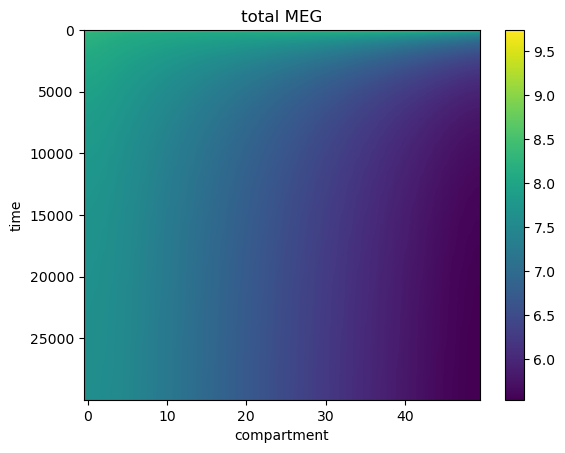

In [4]:
total_MEG = WT_sol[:, range(N)]+WT_sol[:,range(N,2*N)]+WT_sol[:,range(3*N,4*N)]
cs = plt.imshow(total_MEG, aspect='auto')
plt.title('total MEG')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

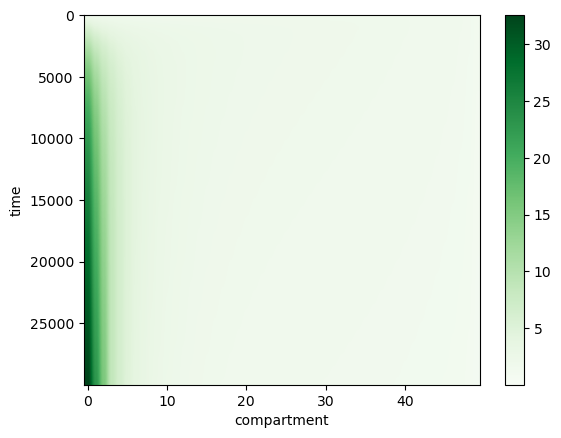

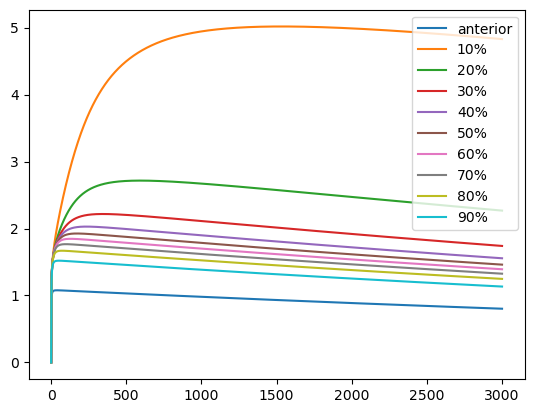

In [5]:
total_PG = WT_sol[:, range(4*N,5*N)]+WT_sol[:,range(5*N,6*N)]+WT_sol[:,range(6*N,7*N)]
cs = plt.imshow(total_PG, aspect='auto', cmap='Greens')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

#plt.plot(t, total_PG[:,0], label='posterior')
plt.plot(t, total_PG[:,49], label='anterior')
plt.plot(t, total_PG[:,5], label='10%')
plt.plot(t, total_PG[:,10], label='20%')
plt.plot(t, total_PG[:,15], label='30%')
plt.plot(t, total_PG[:,20], label='40%')
plt.plot(t, total_PG[:,25], label='50%')
plt.plot(t, total_PG[:,30], label='60%')
plt.plot(t, total_PG[:,35], label='70%')
plt.plot(t, total_PG[:,40], label='80%')
plt.plot(t, total_PG[:,45], label='90%')
plt.legend()
plt.show()

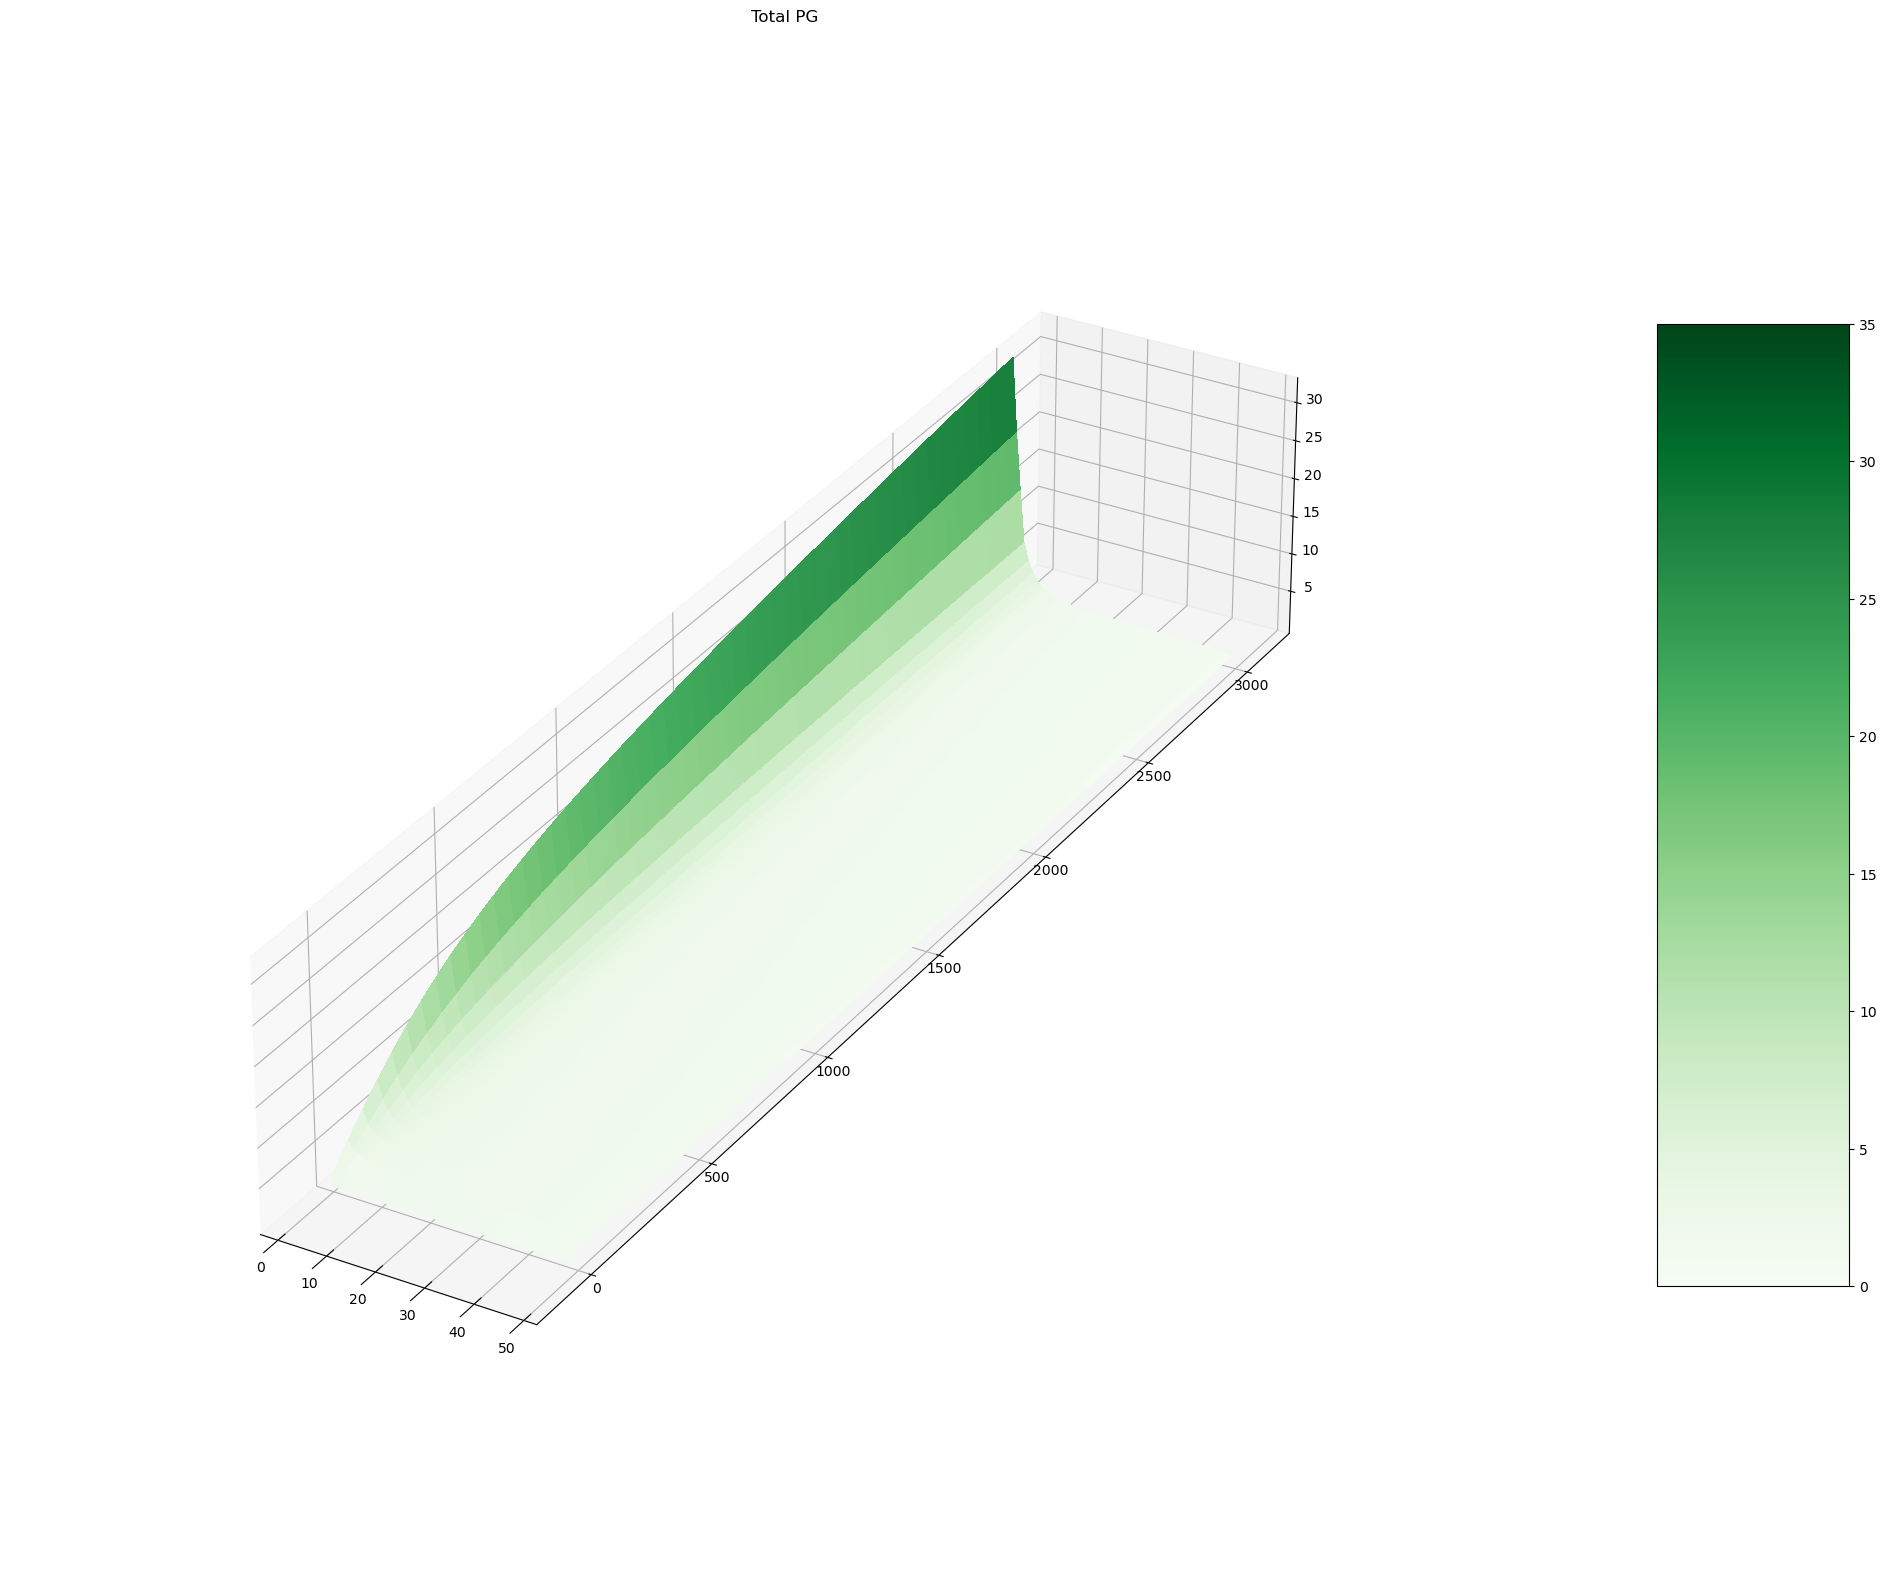

In [7]:
# 3d plot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Total MEG
x = np.arange(0,50,1)
y = t
x,y = np.meshgrid(x, y)

fig1 = plt.figure()
fig1.set_figheight(25)
fig1.set_figwidth(25)
ax = fig1.add_subplot(111, projection='3d')

total_PG = WT_sol[:,range(4*N,5*N)]+WT_sol[:,range(5*N,6*N)]+WT_sol[:,range(6*N,7*N)]

ax.set_box_aspect((1, 5, 1)) 
surf = ax.plot_surface(x, y, total_PG, cmap='Greens',
                       linewidth=0, antialiased=False, vmin=0, vmax=35)
ax.set_title("Total PG")
fig1.colorbar(surf, shrink=0.5, aspect=5)

In [8]:
# mex-5 KO
# will mean no PLK-1 grad, no phosphatase grad, reduced Pase activity and no RNA grad

# get PG formation throughout, as expected
tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0
kcat1_km1=3.6*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.75
n1=50
Kd2=9.75
n2=50

RNA_overall_conc=150
RNA_grad=0
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

MEX5_KO_sol=odeint(need_MR_PG, init, t, params) 

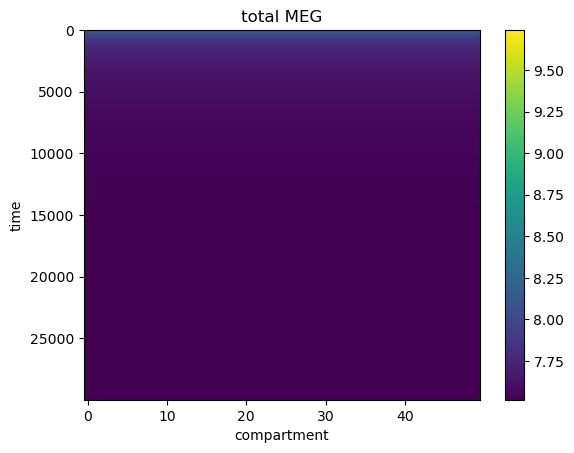

In [9]:
total_MEG = MEX5_KO_sol[:, range(N)]+MEX5_KO_sol[:,range(N,2*N)]+MEX5_KO_sol[:,range(3*N,4*N)]
cs = plt.imshow(total_MEG, aspect='auto')
plt.title('total MEG')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

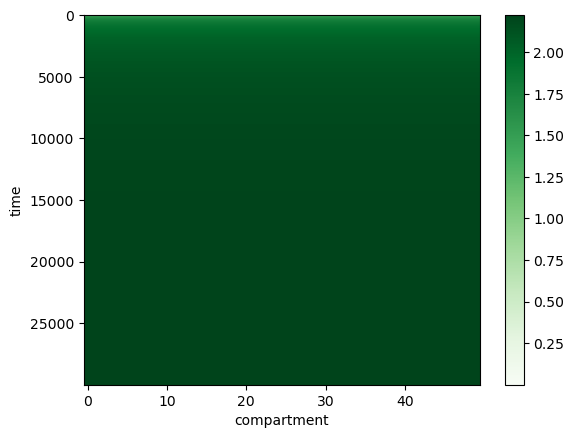

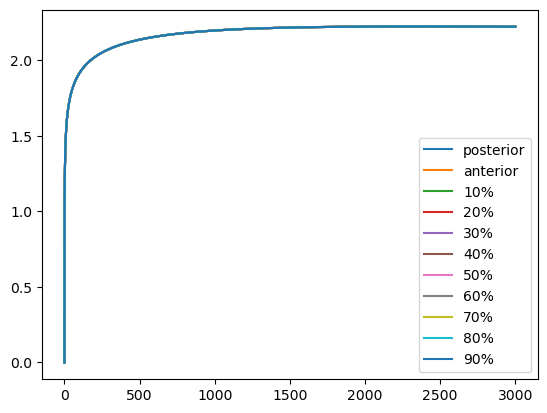

In [10]:
total_PG = MEX5_KO_sol[:, range(4*N,5*N)]+MEX5_KO_sol[:,range(5*N,6*N)]+MEX5_KO_sol[:,range(6*N,7*N)]
cs = plt.imshow(total_PG, aspect='auto', cmap='Greens')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

plt.plot(t, total_PG[:,0], label='posterior')
plt.plot(t, total_PG[:,49], label='anterior')
plt.plot(t, total_PG[:,5], label='10%')
plt.plot(t, total_PG[:,10], label='20%')
plt.plot(t, total_PG[:,15], label='30%')
plt.plot(t, total_PG[:,20], label='40%')
plt.plot(t, total_PG[:,25], label='50%')
plt.plot(t, total_PG[:,30], label='60%')
plt.plot(t, total_PG[:,35], label='70%')
plt.plot(t, total_PG[:,40], label='80%')
plt.plot(t, total_PG[:,45], label='90%')
plt.legend()
plt.show()

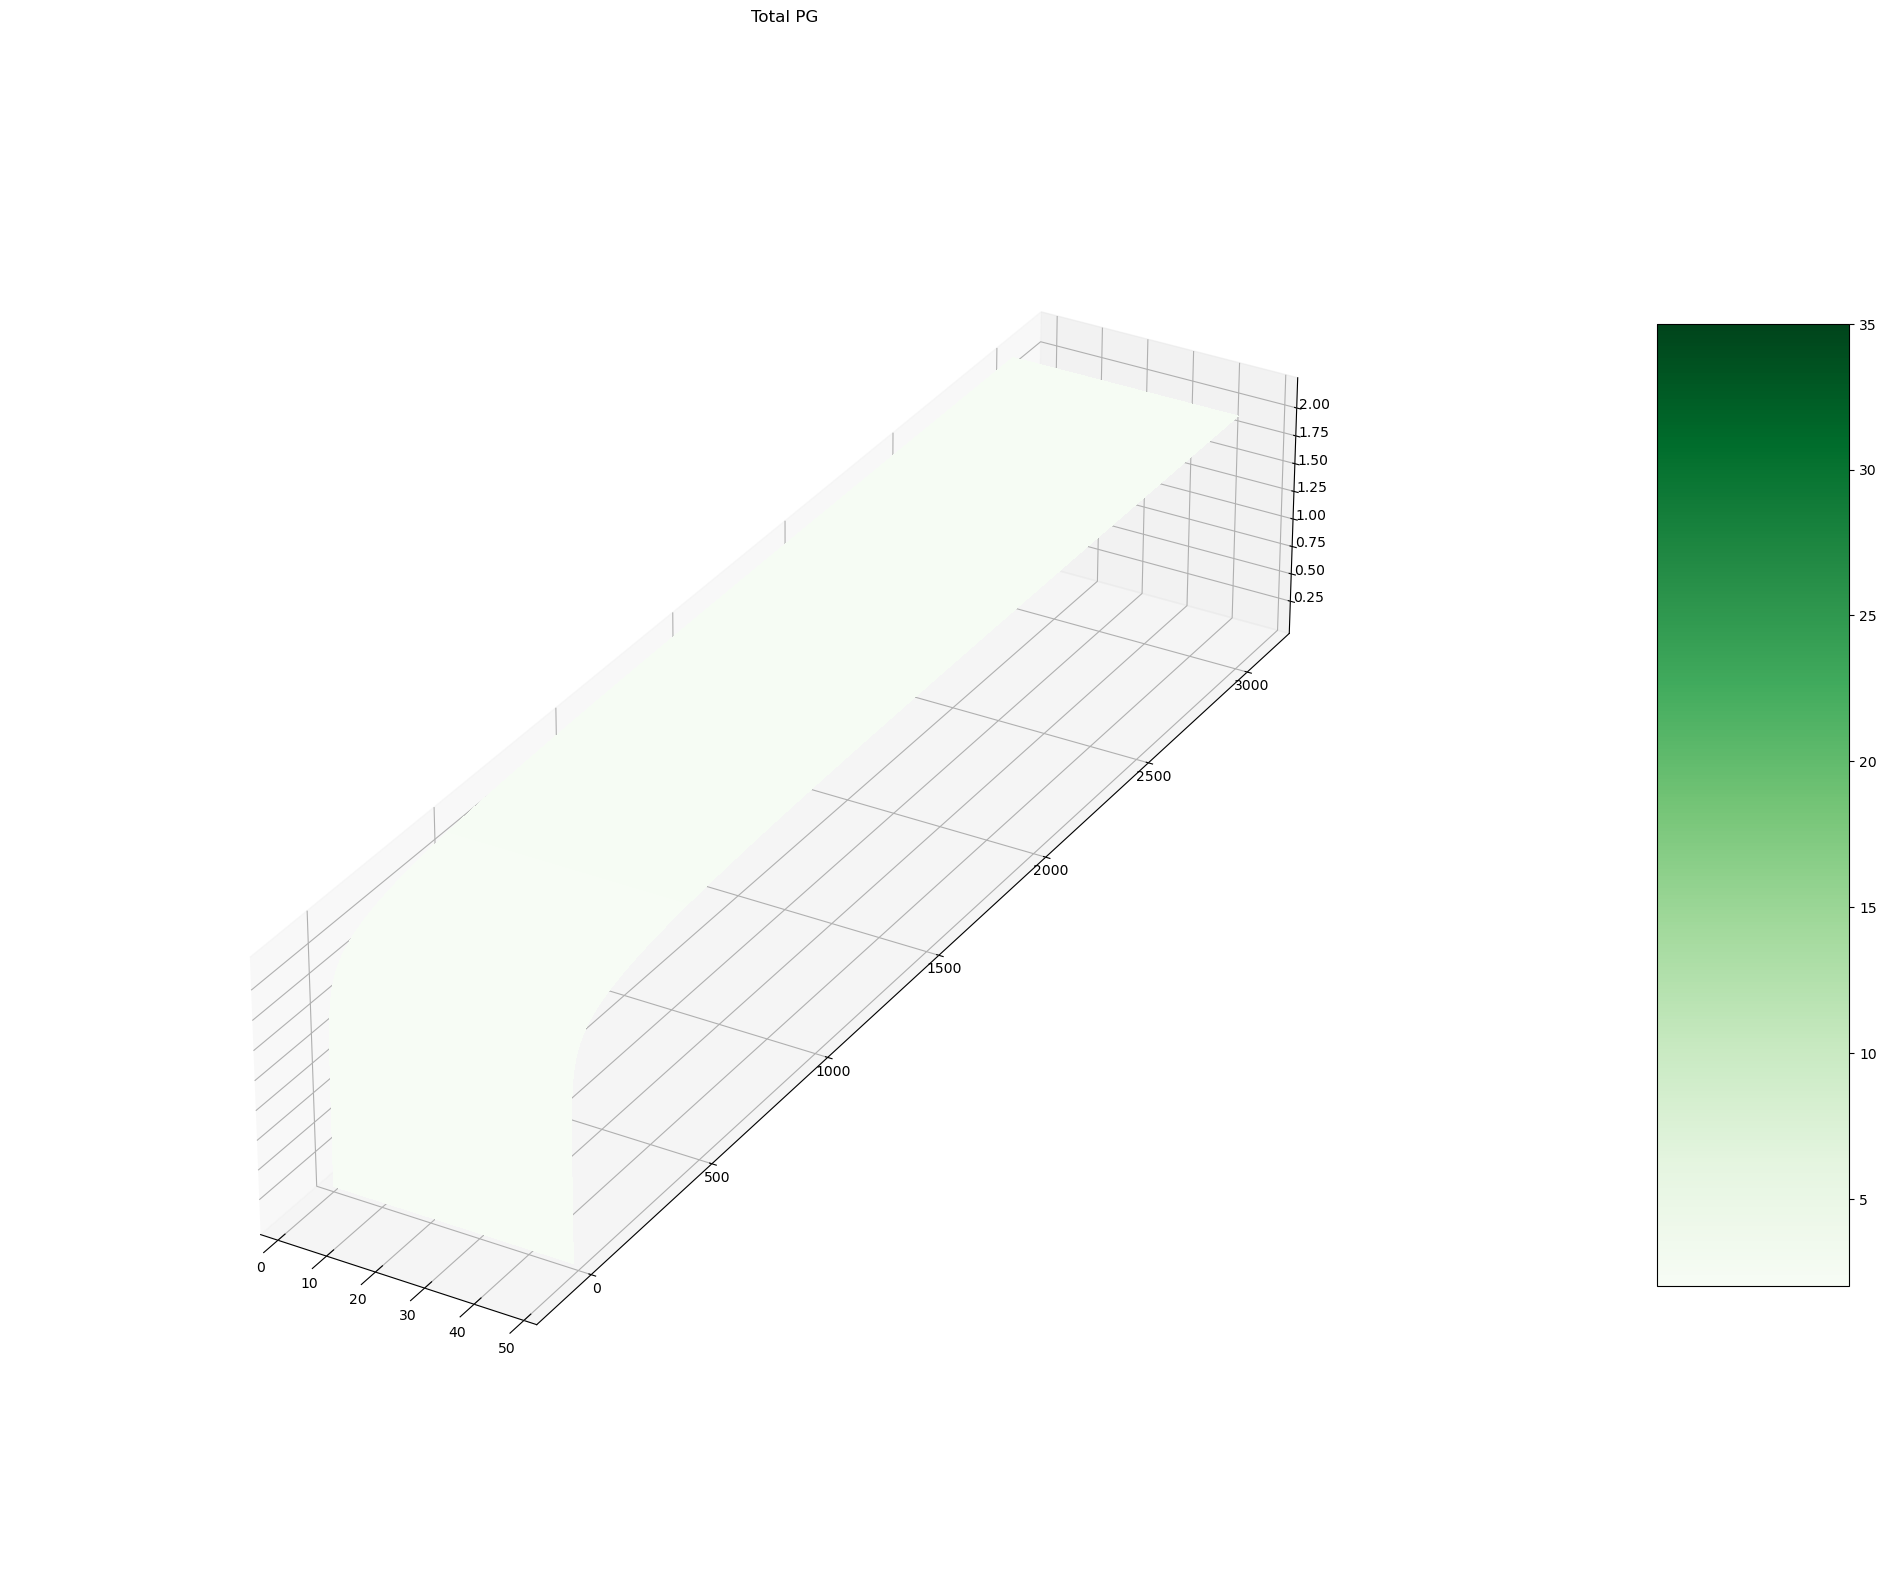

In [20]:
# 3d plot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Total MEG
x = np.arange(0,50,1)
y = t
x,y = np.meshgrid(x, y)

fig1 = plt.figure()
fig1.set_figheight(25)
fig1.set_figwidth(25)
ax = fig1.add_subplot(111, projection='3d')

total_PG = MEX5_KO_sol[:,range(4*N,5*N)]+MEX5_KO_sol[:,range(5*N,6*N)]+MEX5_KO_sol[:,range(6*N,7*N)]

ax.set_box_aspect((1, 5, 1)) 
surf = ax.plot_surface(x, y, total_PG,
                       linewidth=0, antialiased=False)
surf = ax.plot_surface(x, y, total_PG, cmap='Greens',
                       linewidth=0, antialiased=False, vmin=2, vmax=35)
ax.set_title("Total PG")
fig1.colorbar(surf, shrink=0.5, aspect=5)

In [12]:
# plk-1 KO - expect boundary to be more anterior

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=0
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

PLK1KO_sol=odeint(need_MR_PG, init, t, params) 

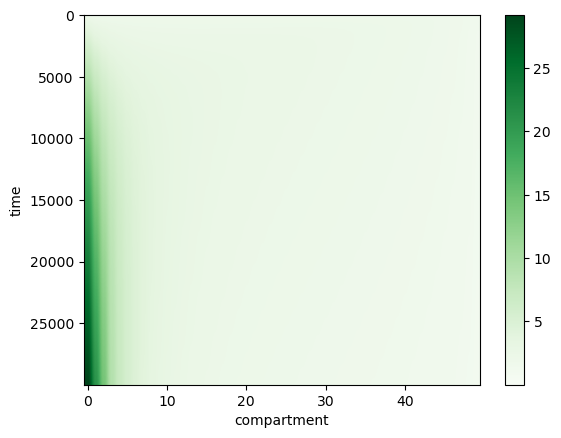

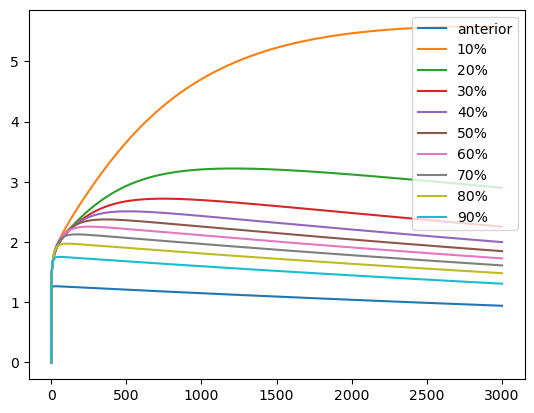

In [13]:
total_PG = PLK1KO_sol[:, range(4*N,5*N)]+PLK1KO_sol[:,range(5*N,6*N)]+PLK1KO_sol[:,range(6*N,7*N)]
cs = plt.imshow(total_PG, aspect='auto', cmap='Greens')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

#plt.plot(t, total_PG[:,0], label='posterior')
plt.plot(t, total_PG[:,49], label='anterior')
plt.plot(t, total_PG[:,5], label='10%')
plt.plot(t, total_PG[:,10], label='20%')
plt.plot(t, total_PG[:,15], label='30%')
plt.plot(t, total_PG[:,20], label='40%')
plt.plot(t, total_PG[:,25], label='50%')
plt.plot(t, total_PG[:,30], label='60%')
plt.plot(t, total_PG[:,35], label='70%')
plt.plot(t, total_PG[:,40], label='80%')
plt.plot(t, total_PG[:,45], label='90%')
plt.legend()
plt.show()

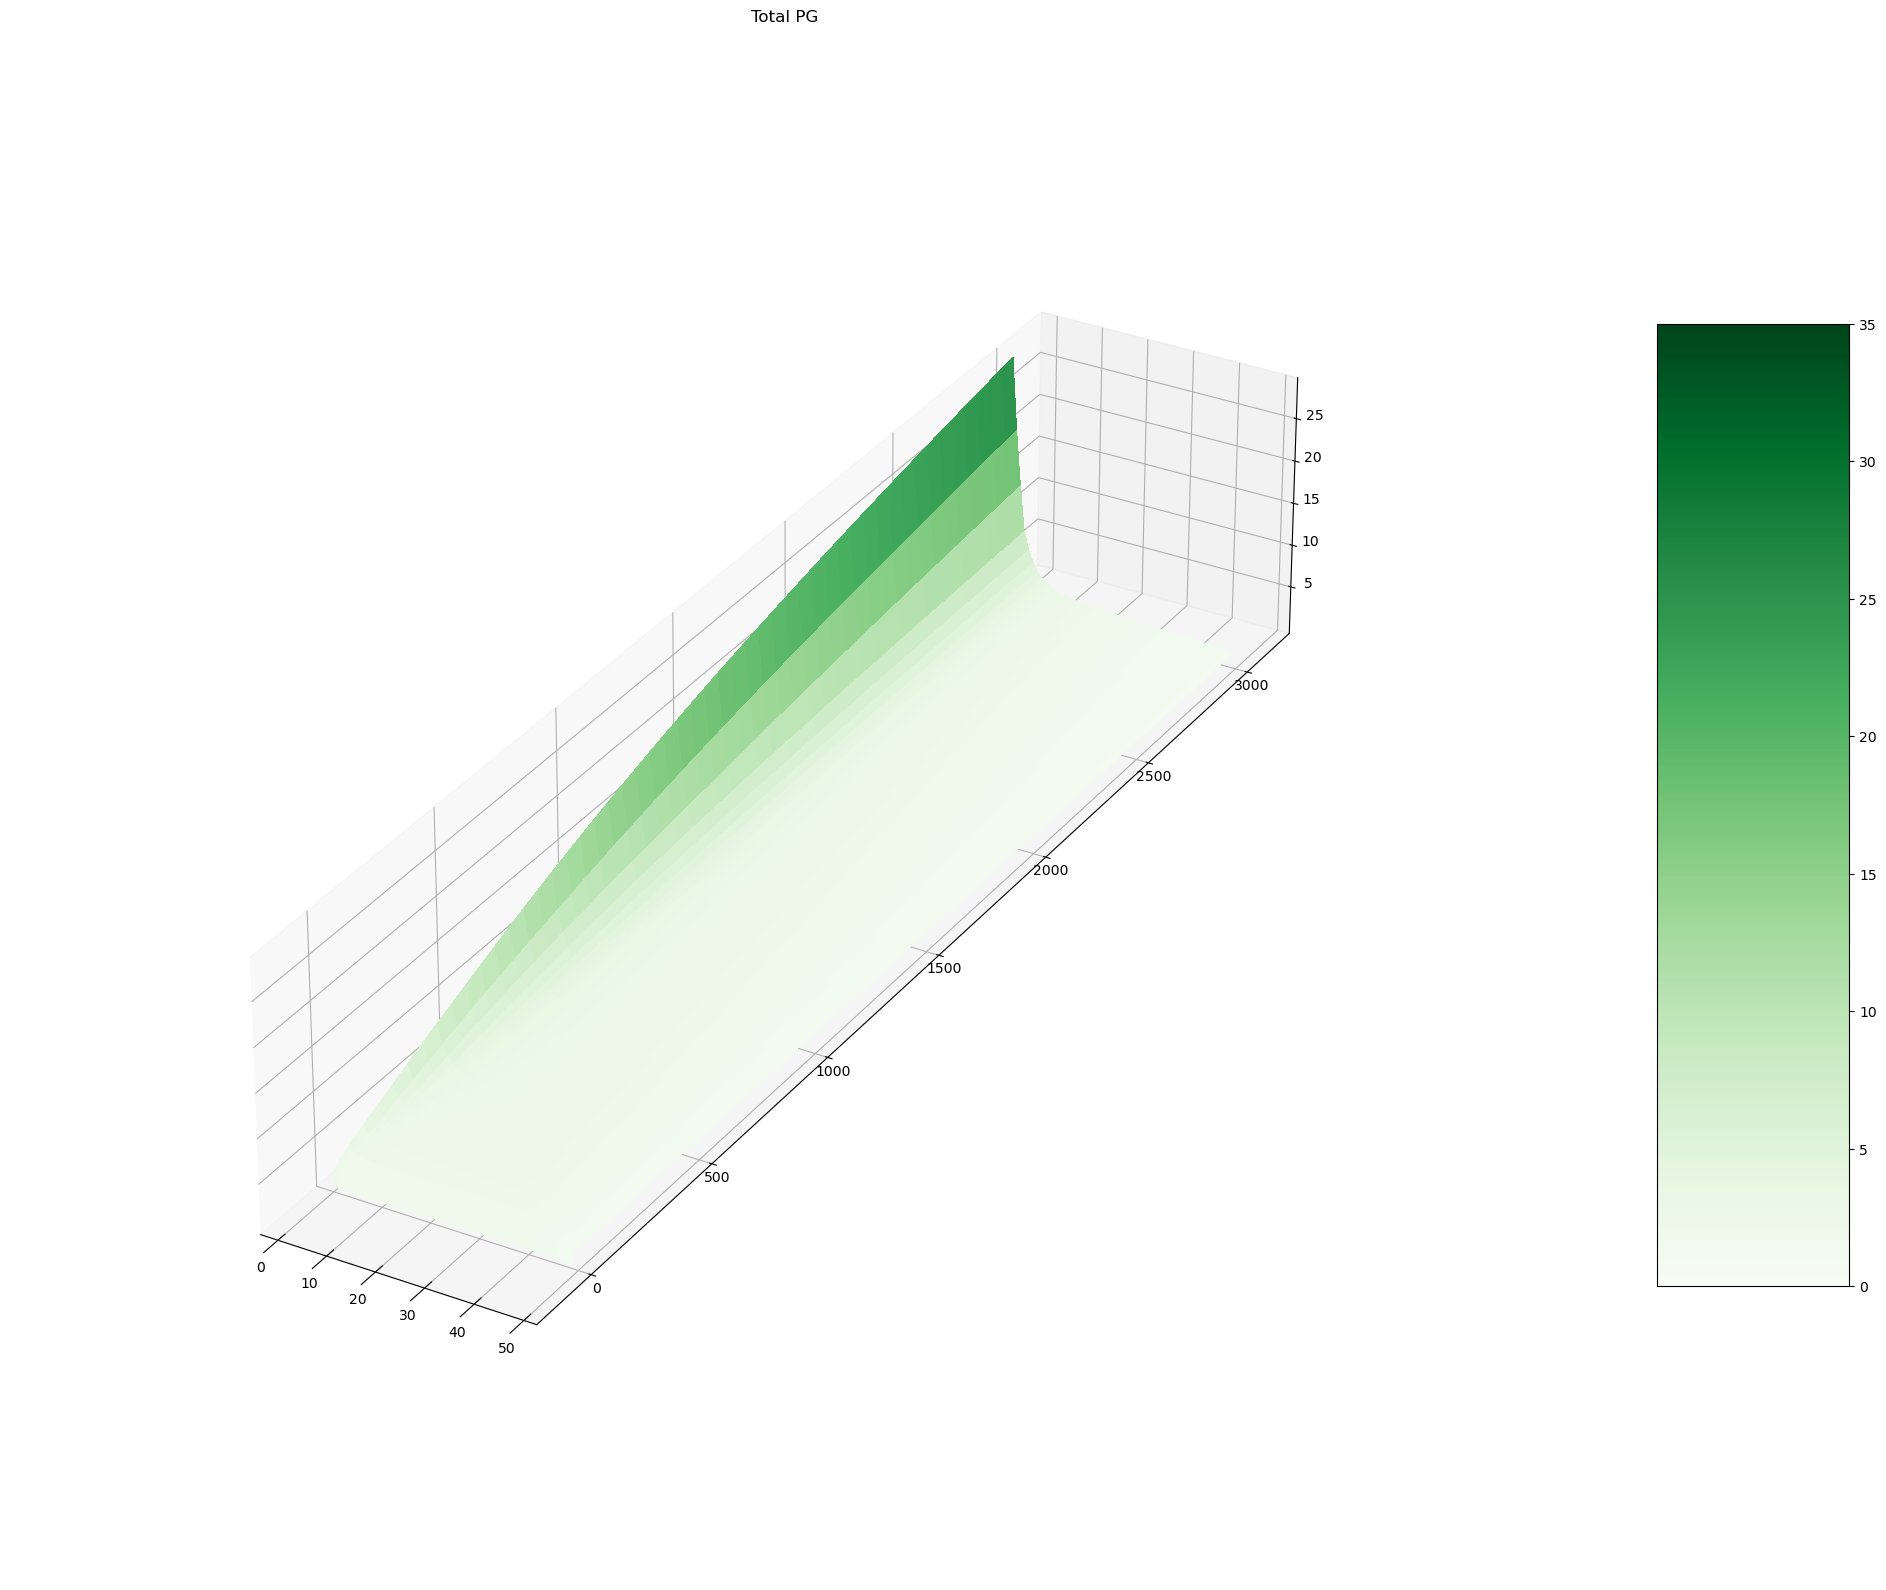

In [29]:
# 3d plot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Total MEG
x = np.arange(0,50,1)
y = t
x,y = np.meshgrid(x, y)

fig1 = plt.figure()
fig1.set_figheight(25)
fig1.set_figwidth(25)
ax = fig1.add_subplot(111, projection='3d')

total_PG = PLK1KO_sol[:,range(4*N,5*N)]+PLK1KO_sol[:,range(5*N,6*N)]+PLK1KO_sol[:,range(6*N,7*N)]

ax.set_box_aspect((1, 5, 1)) 
surf = ax.plot_surface(x, y, total_PG, cmap='Greens',
                       linewidth=0, antialiased=False, vmin=0, vmax=35)
ax.set_title("Total PG")
fig1.colorbar(surf, shrink=0.5, aspect=5)

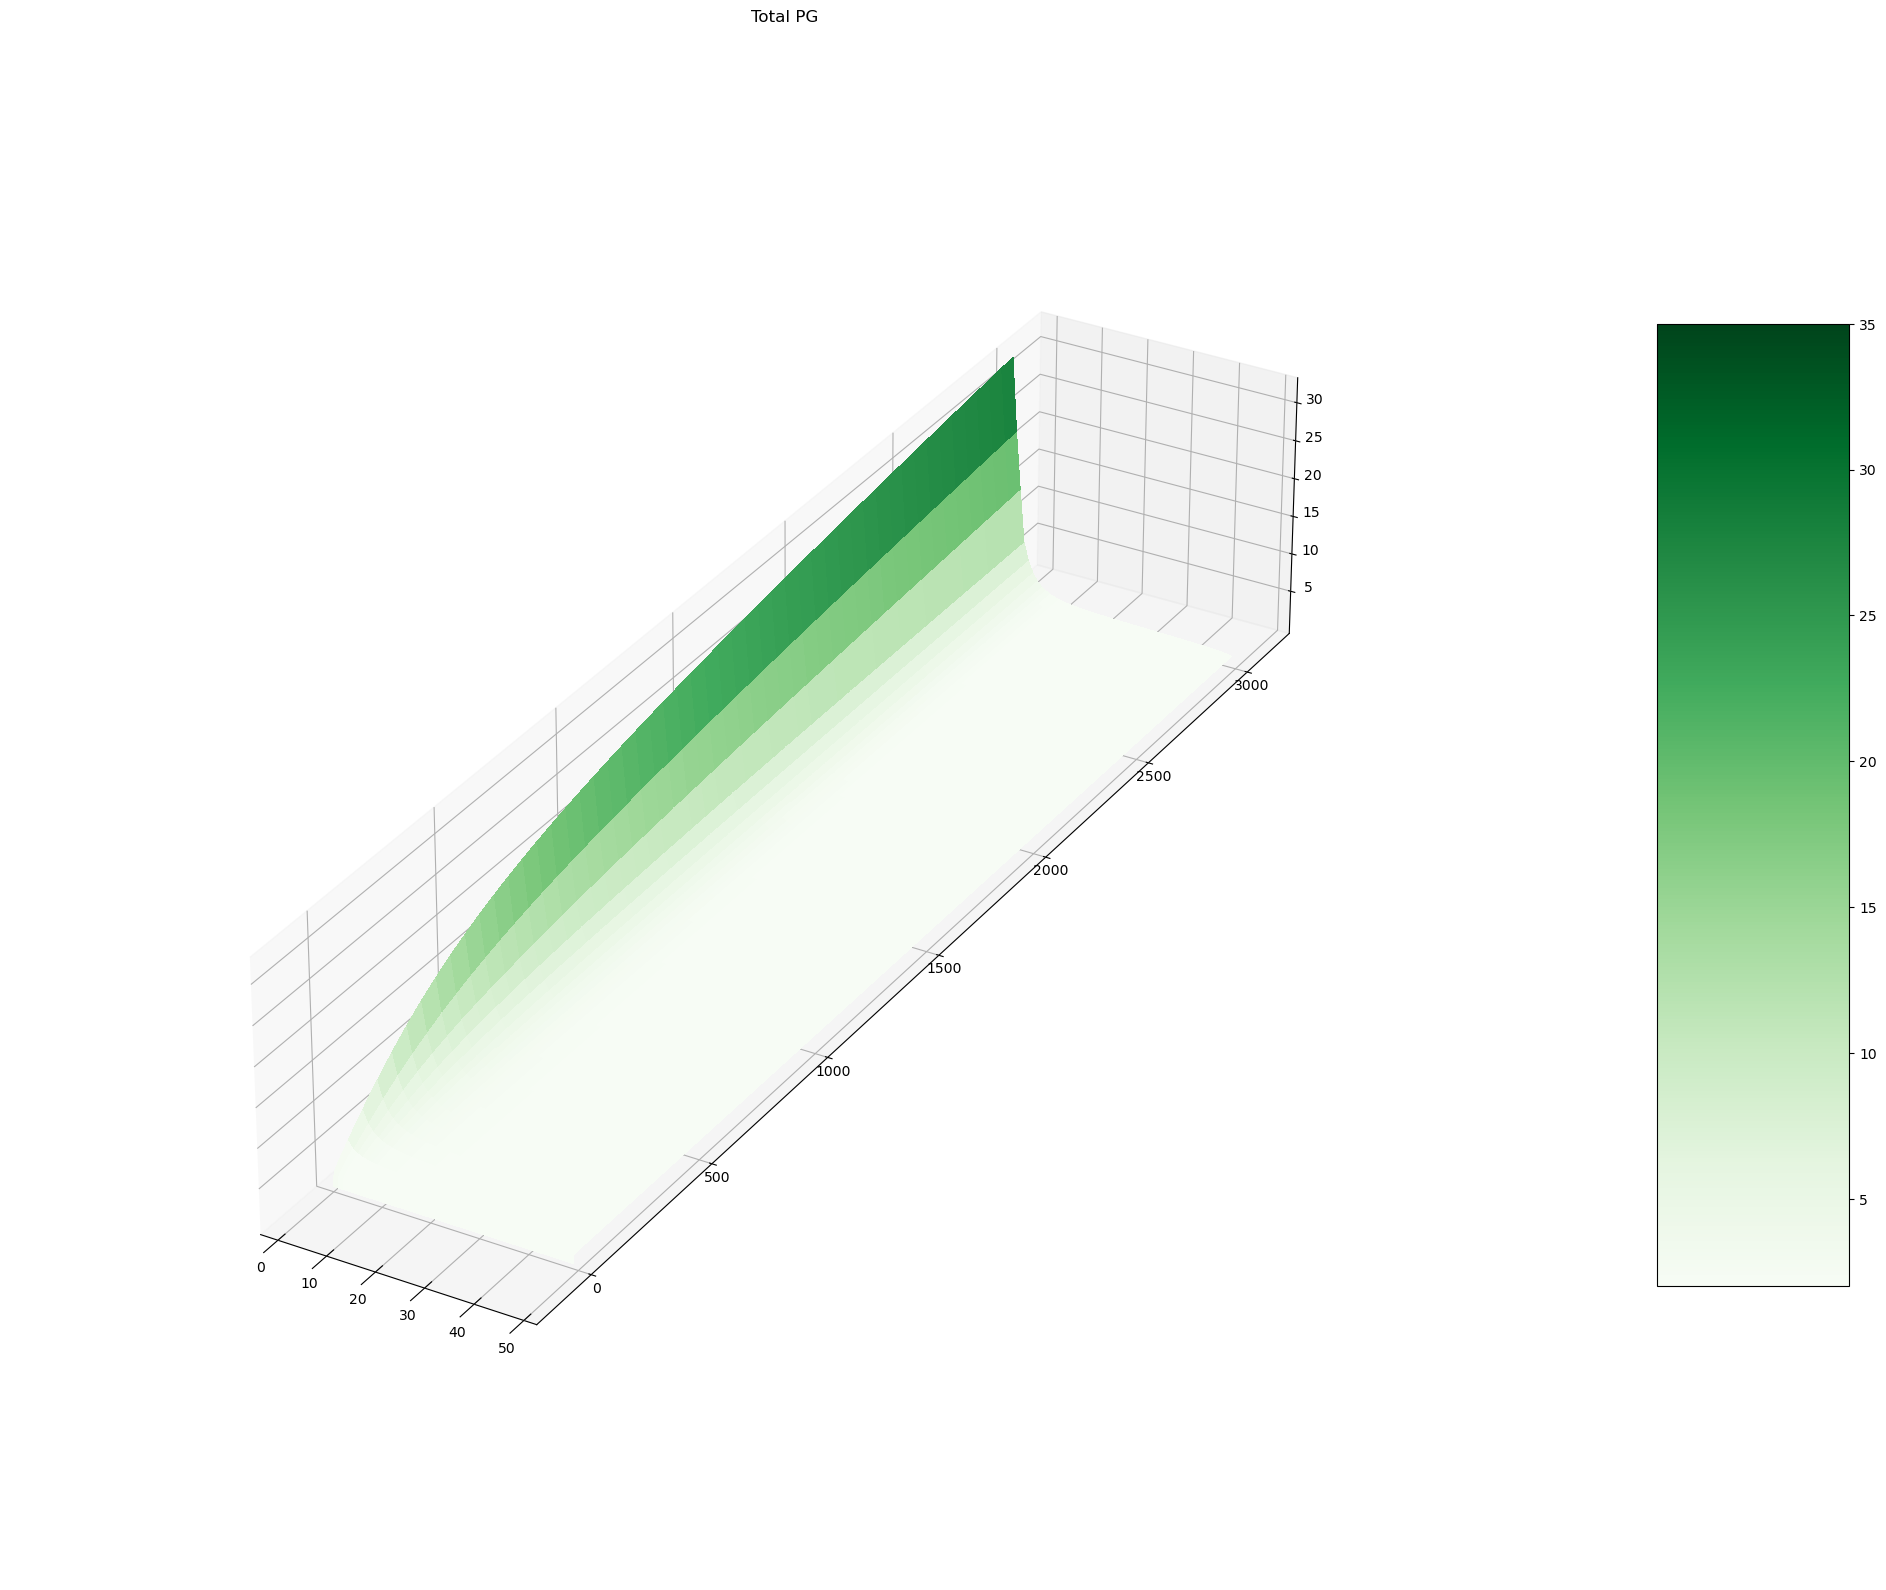

In [27]:
# 3d plot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Total MEG
x = np.arange(0,50,1)
y = t
x,y = np.meshgrid(x, y)

fig1 = plt.figure()
fig1.set_figheight(25)
fig1.set_figwidth(25)
ax = fig1.add_subplot(111, projection='3d')

total_PG = WT_sol[:,range(4*N,5*N)]+WT_sol[:,range(5*N,6*N)]+WT_sol[:,range(6*N,7*N)]

ax.set_box_aspect((1, 5, 1)) 
surf = ax.plot_surface(x, y, total_PG, cmap='Greens',
                       linewidth=0, antialiased=False, vmin=2, vmax=35)
ax.set_title("Total PG")
fig1.colorbar(surf, shrink=0.5, aspect=5)

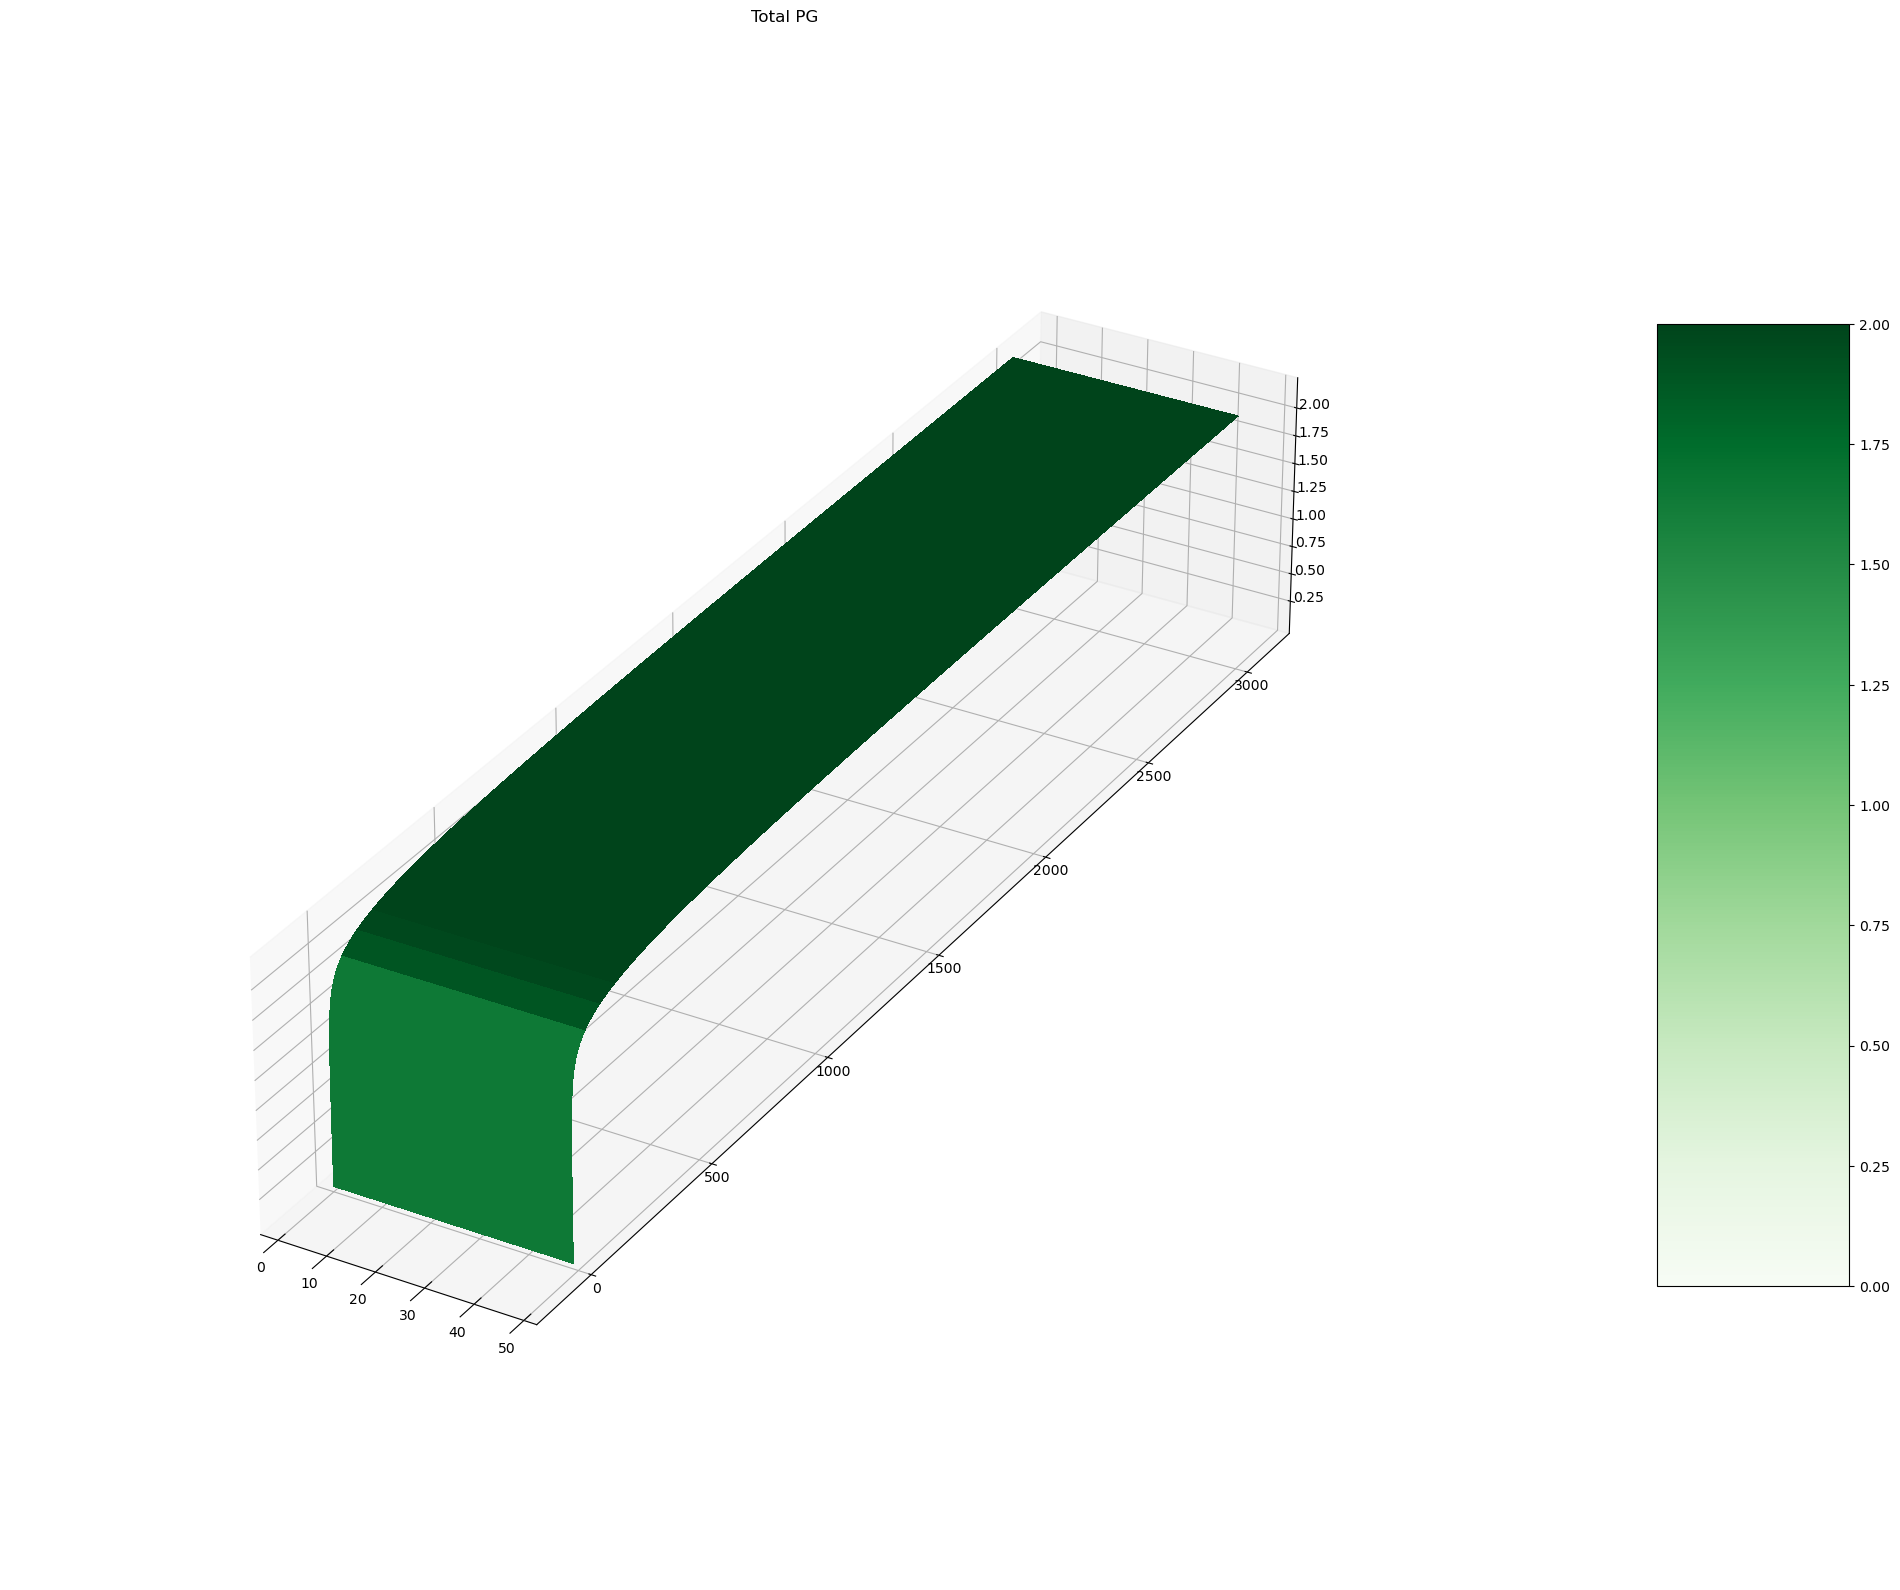

In [28]:
# 3d plot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Total MEG
x = np.arange(0,50,1)
y = t
x,y = np.meshgrid(x, y)

fig1 = plt.figure()
fig1.set_figheight(25)
fig1.set_figwidth(25)
ax = fig1.add_subplot(111, projection='3d')

total_PG = MEX5_KO_sol[:,range(4*N,5*N)]+MEX5_KO_sol[:,range(5*N,6*N)]+MEX5_KO_sol[:,range(6*N,7*N)]

ax.set_box_aspect((1, 5, 1)) 
surf = ax.plot_surface(x, y, total_PG, cmap='Greens',
                       linewidth=0, antialiased=False, vmin=0, vmax=2)
ax.set_title("Total PG")
fig1.colorbar(surf, shrink=0.5, aspect=5)

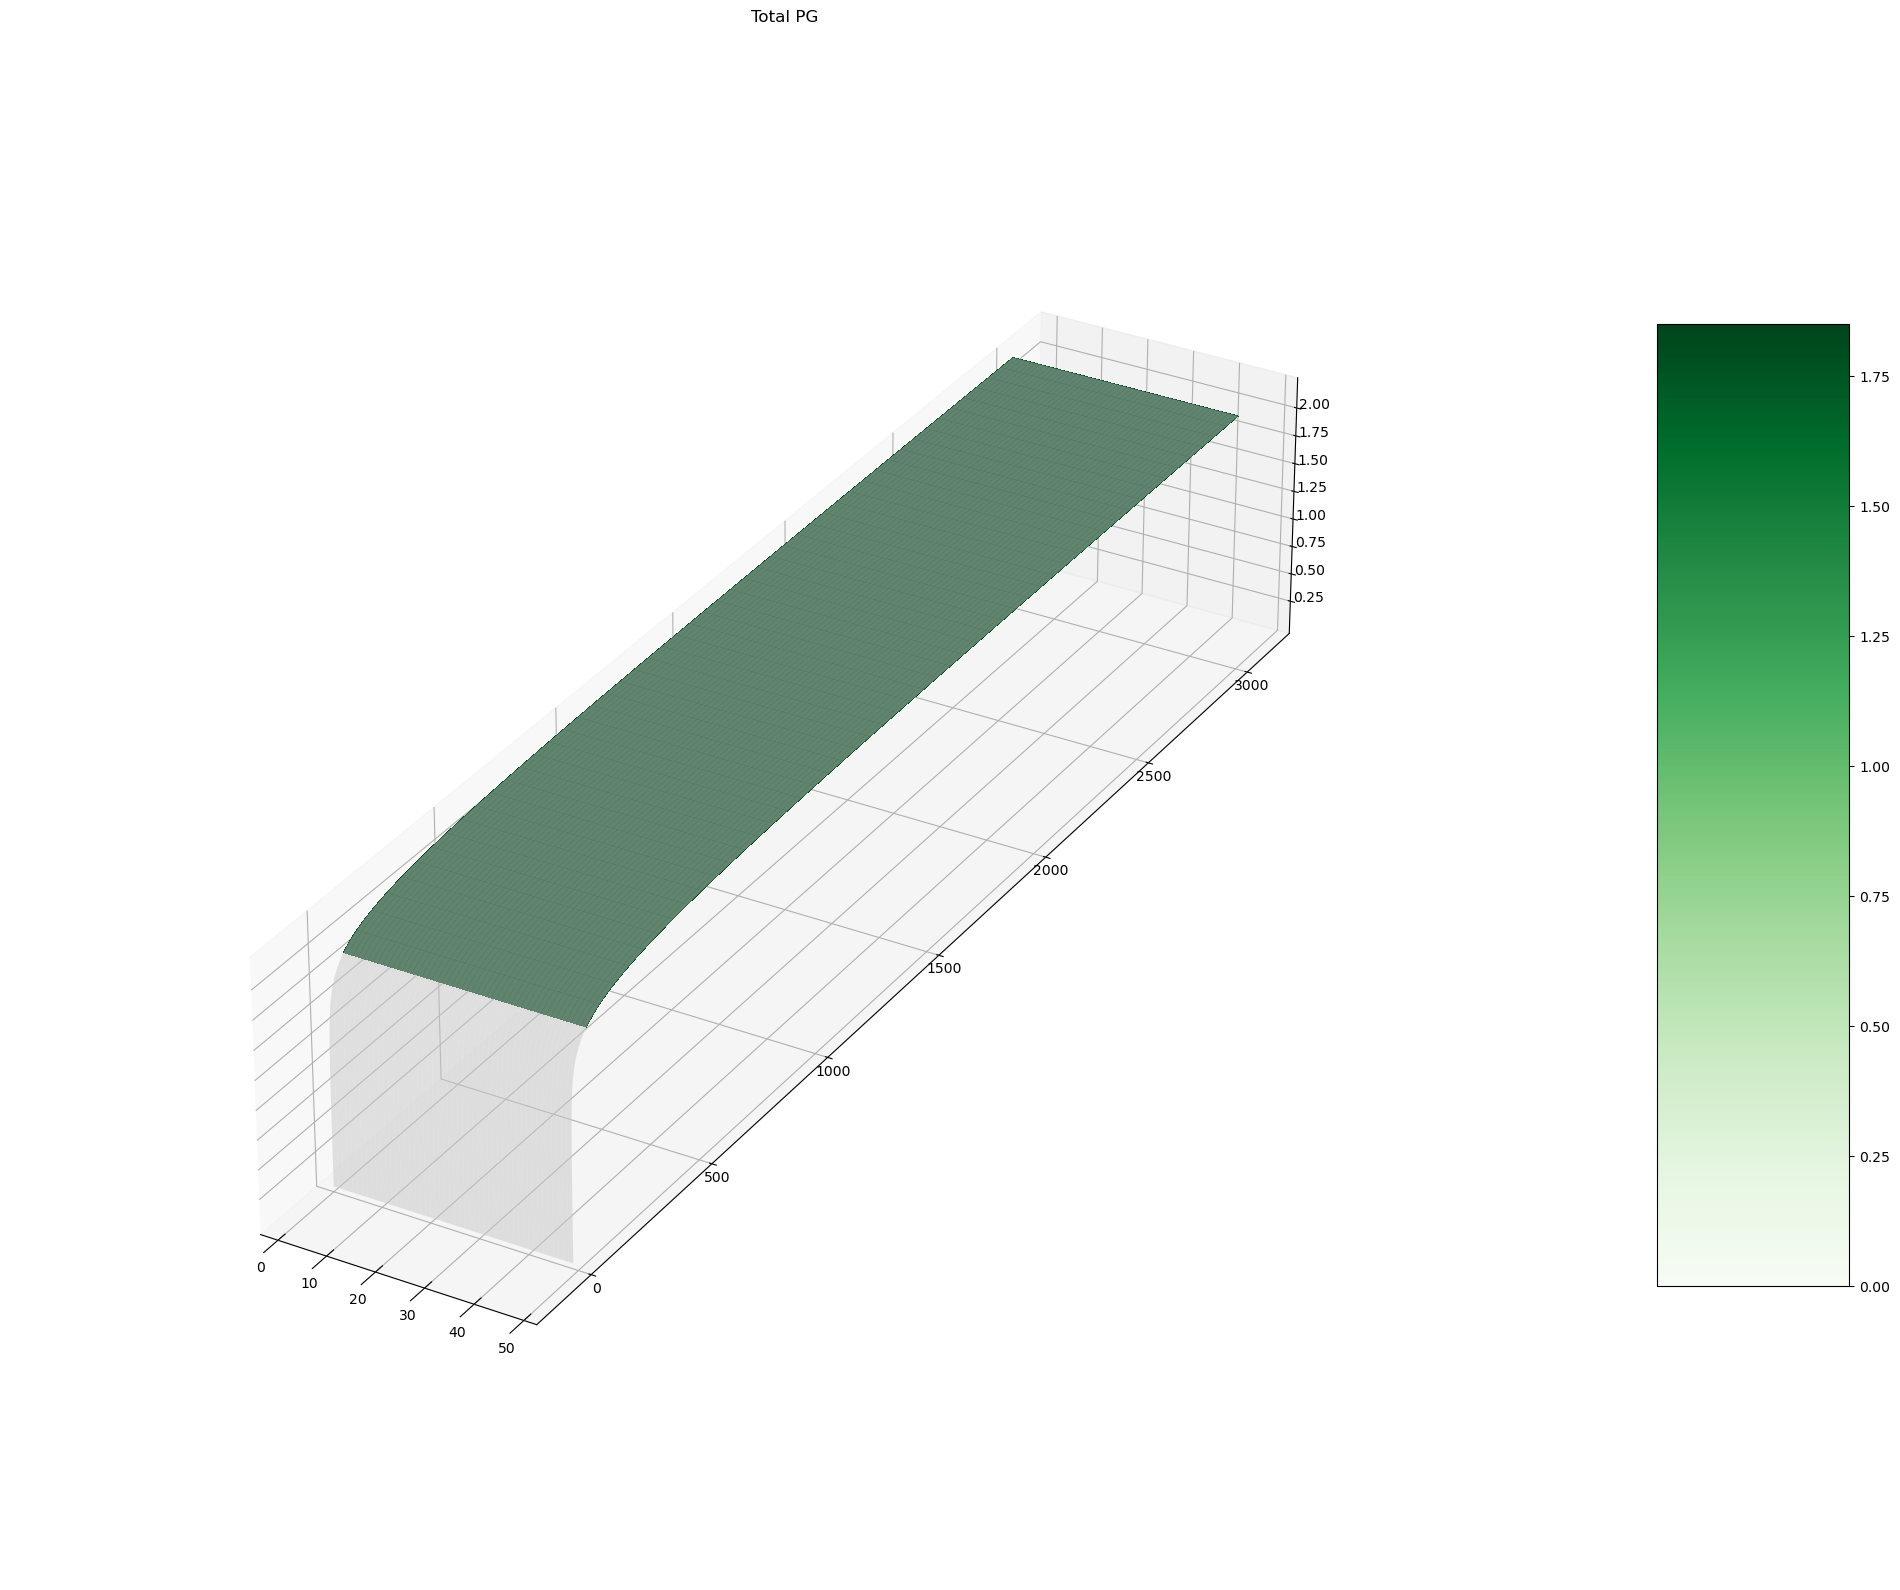

In [45]:
# 3d plot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Total MEG
x = np.arange(0,50,1)
y = t
x,y = np.meshgrid(x, y)

fig1 = plt.figure()
fig1.set_figheight(25)
fig1.set_figwidth(25)
ax = fig1.add_subplot(111, projection='3d')

total_PG = MEX5_KO_sol[:,range(4*N,5*N)]+MEX5_KO_sol[:,range(5*N,6*N)]+MEX5_KO_sol[:,range(6*N,7*N)]
masked_z = np.ma.masked_where(total_PG <= 1.85, total_PG)

ax.set_box_aspect((1, 5, 1)) 
ax.plot_surface(x, y, total_PG, color='white', alpha=0.5)
surf = ax.plot_surface(x, y, masked_z, cmap='Greens',
                       linewidth=0, antialiased=False, vmin=0, vmax=1.85)
ax.set_title("Total PG")
fig1.colorbar(surf, shrink=0.5, aspect=5)

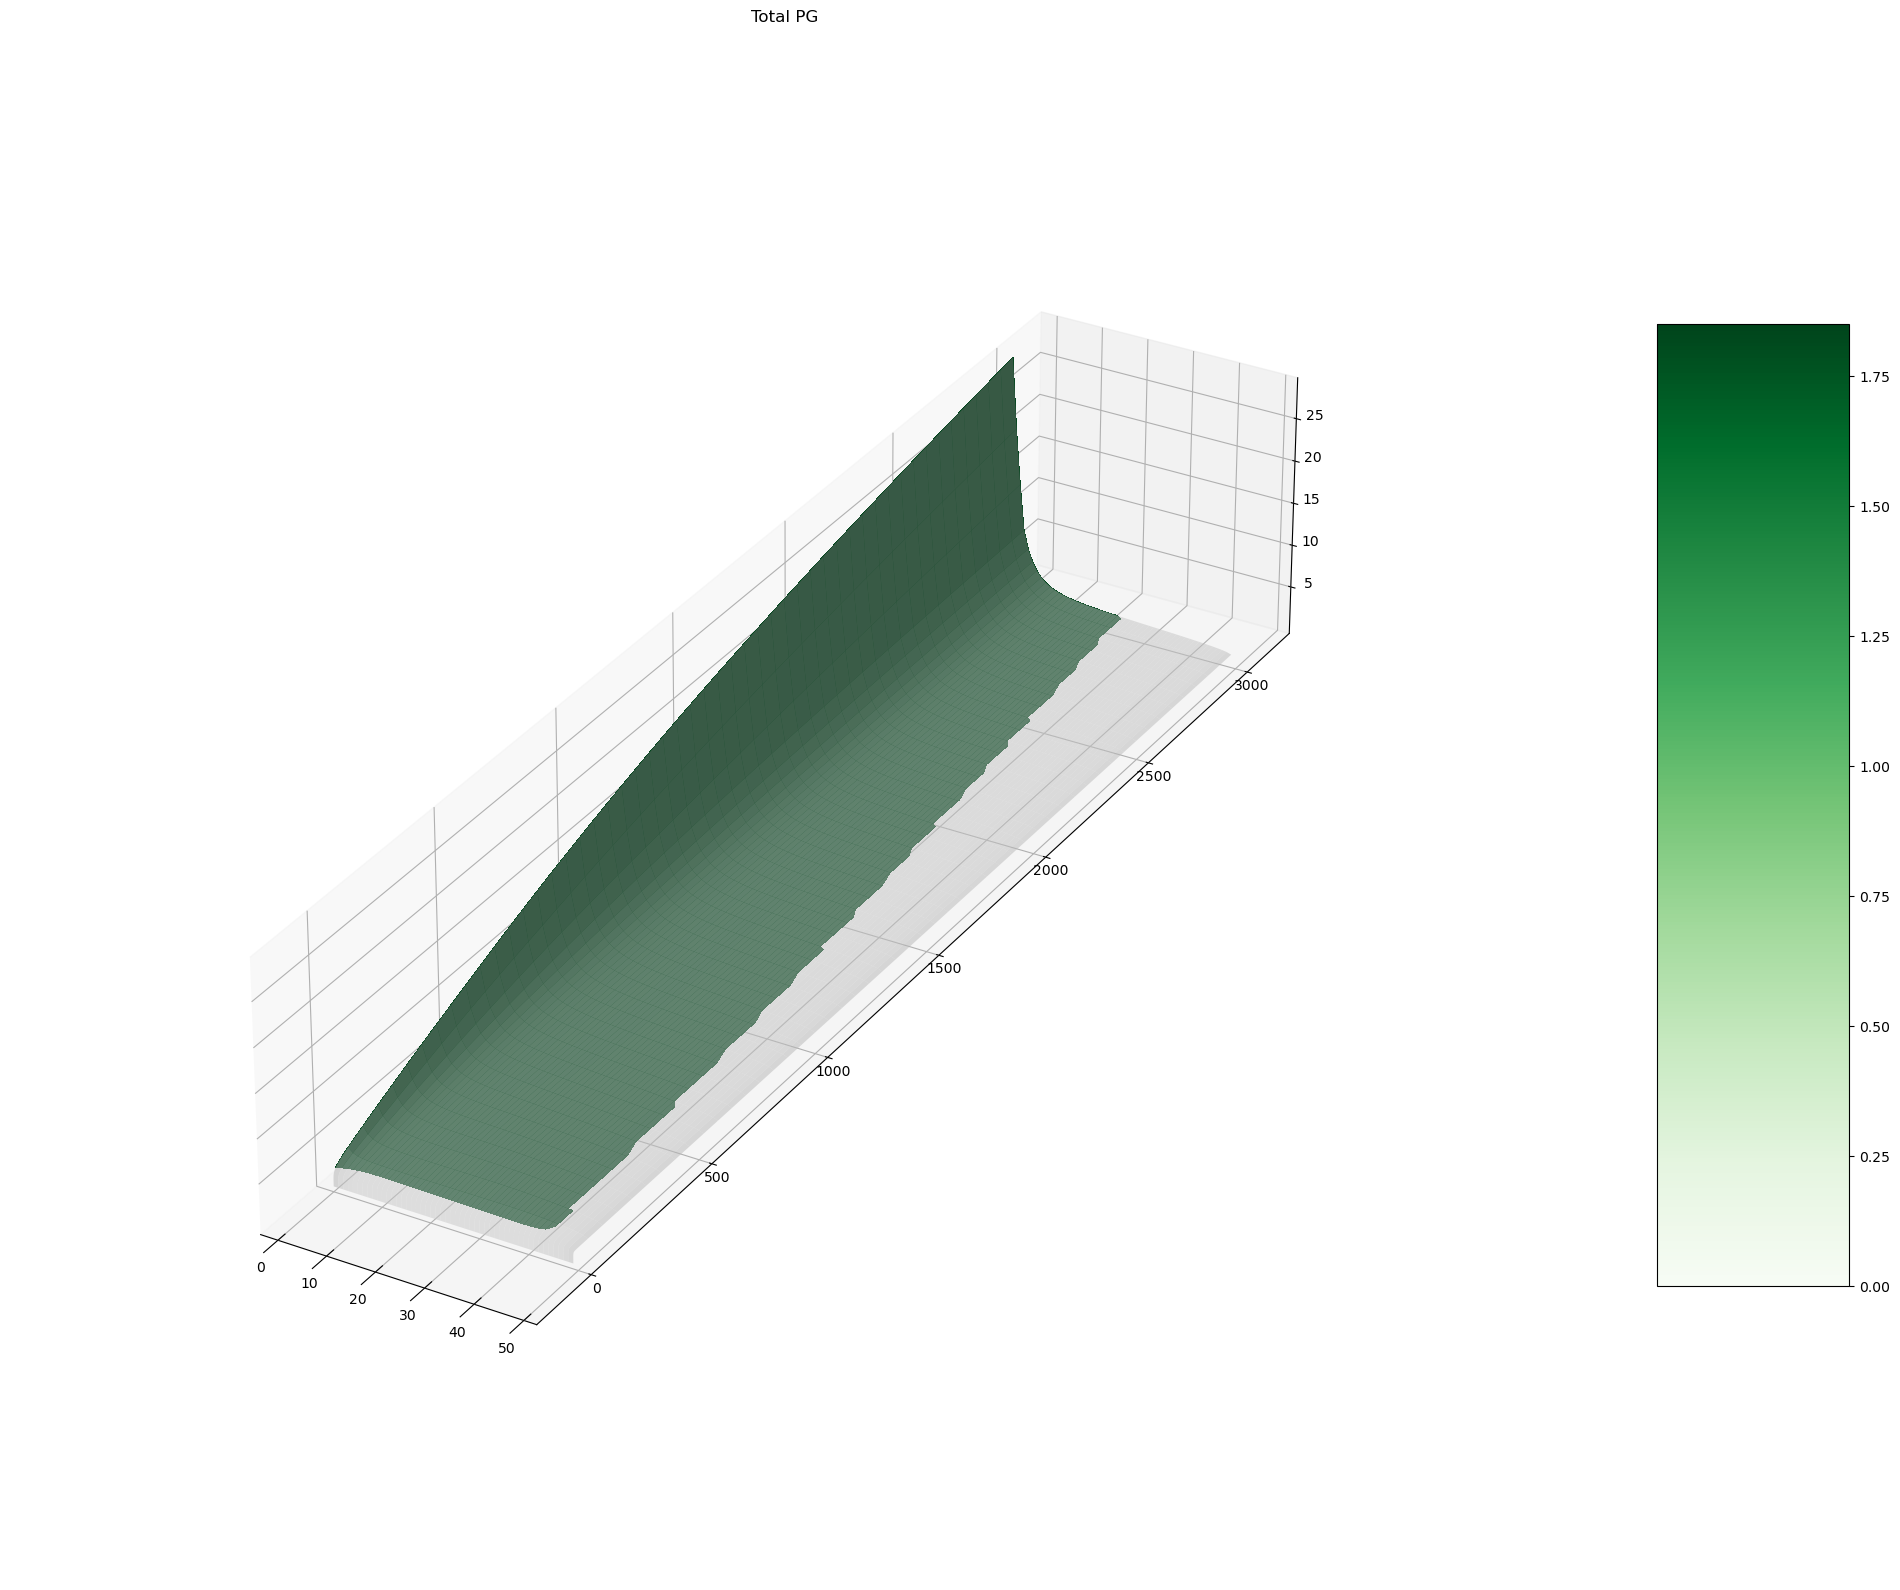

In [44]:
# 3d plot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Total MEG
x = np.arange(0,50,1)
y = t
x,y = np.meshgrid(x, y)

fig1 = plt.figure()
fig1.set_figheight(25)
fig1.set_figwidth(25)
ax = fig1.add_subplot(111, projection='3d')

total_PG = PLK1KO_sol[:,range(4*N,5*N)]+PLK1KO_sol[:,range(5*N,6*N)]+PLK1KO_sol[:,range(6*N,7*N)]
masked_z = np.ma.masked_where(total_PG <= 1.85, total_PG)

ax.set_box_aspect((1, 5, 1)) 
ax.plot_surface(x, y, total_PG, color='white', alpha=0.5)
surf = ax.plot_surface(x, y, masked_z, cmap='Greens',
                       linewidth=0, antialiased=False, vmin=0, vmax=1.85)
ax.set_title("Total PG")
fig1.colorbar(surf, shrink=0.5, aspect=5)

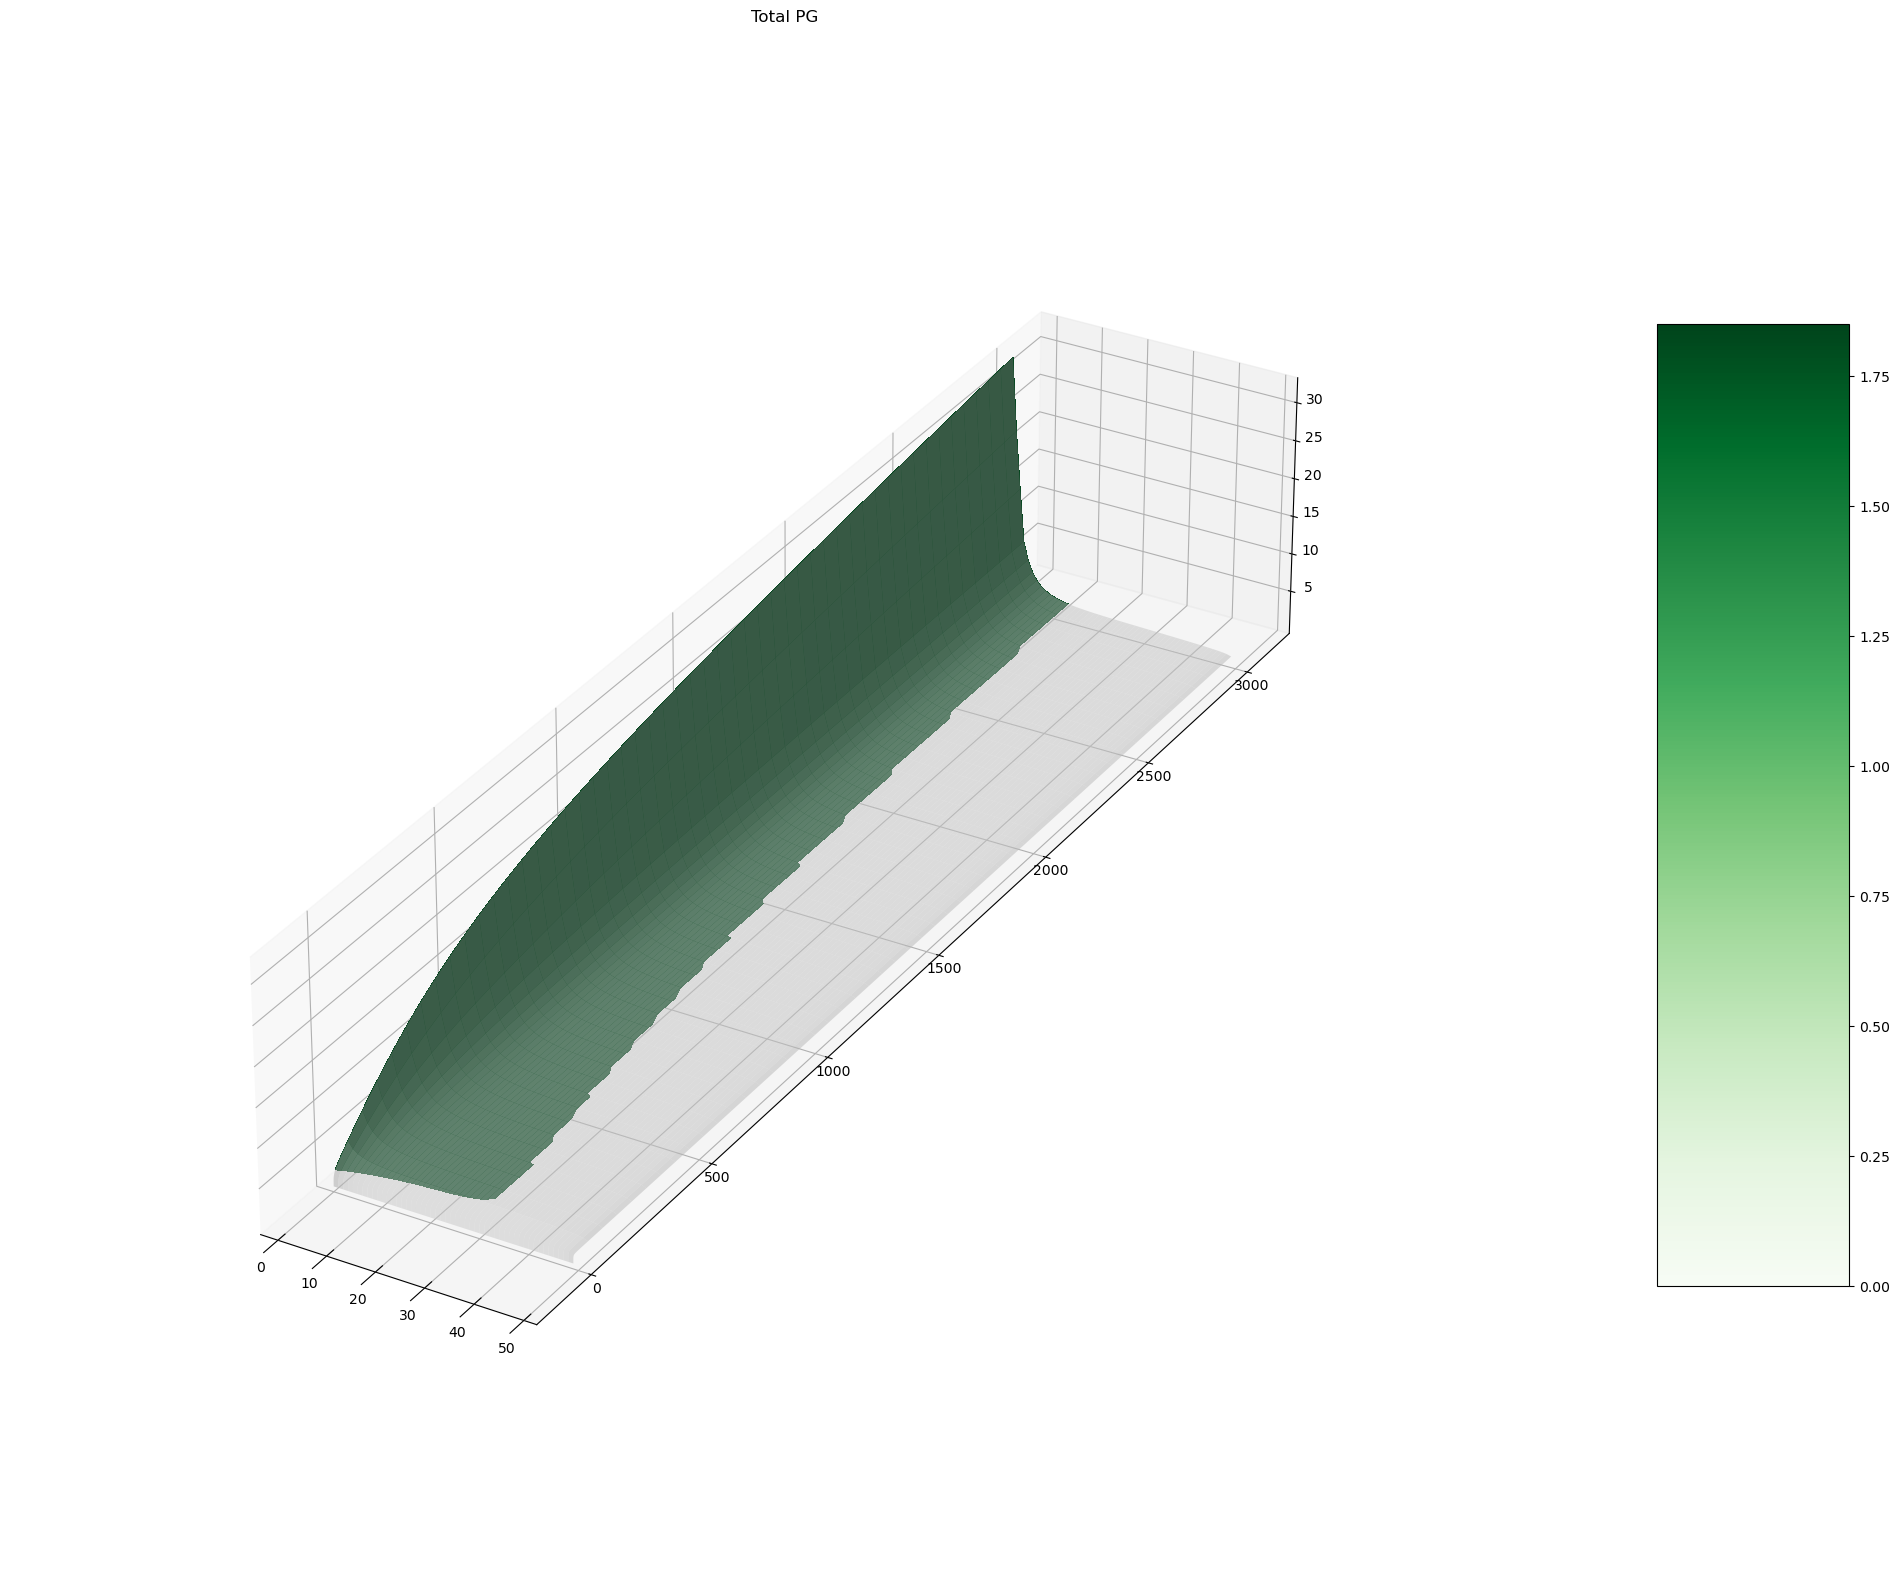

In [43]:
# 3d plot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Total MEG
x = np.arange(0,50,1)
y = t
x,y = np.meshgrid(x, y)

fig1 = plt.figure()
fig1.set_figheight(25)
fig1.set_figwidth(25)
ax = fig1.add_subplot(111, projection='3d')

total_PG = WT_sol[:,range(4*N,5*N)]+WT_sol[:,range(5*N,6*N)]+WT_sol[:,range(6*N,7*N)]
masked_z = np.ma.masked_where(total_PG <= 1.85, total_PG)

ax.set_box_aspect((1, 5, 1)) 
ax.plot_surface(x, y, total_PG, color='white', alpha=0.5)
surf = ax.plot_surface(x, y, masked_z, cmap='Greens',
                       linewidth=0, antialiased=False, vmin=0, vmax=1.85)
ax.set_title("Total PG")
fig1.colorbar(surf, shrink=0.5, aspect=5)

In [ ]:
tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
#params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

PG_boundaries_form=[]
PG_boundaries_leave=[]

for KD in np.linspace(0,20,50):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, KD, n1, Kd2, n2)
    sol=odeint(need_MR_PG, init, t, params)
    
    final_PG = sol[29999,range(4*N,5*N)]+sol[29999,range(5*N,6*N)]+sol[29999,range(6*N,7*N)]
    
    for index,PG_conc in enumerate(final_PG):
        if PG_conc>1.85:
            compartment=index
            break
    
    PG_boundaries_form.append(compartment/50)
    
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, KD, n2)
    sol=odeint(need_MR_PG, init, t, params)
    
    final_PG = sol[29999,range(4*N,5*N)]+sol[29999,range(5*N,6*N)]+sol[29999,range(6*N,7*N)]
    
    for index,PG_conc in enumerate(final_PG):
        if PG_conc>1.85:
            compartment=index
            break
    
    PG_boundaries_leave.append(compartment/50)
    
plt.plot(np.linspace(0,20,50), PG_boundaries_form, label = "Kd form")
plt.plot(np.linspace(0,20,50), PG_boundaries_leave, label = "Kd leave")
plt.xlabel('Kd')
plt.ylabel('PG boundary')
plt.legend(loc='best')
plt.show()

In [ ]:
tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
#params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

PG_boundaries_form=[]
PG_boundaries_leave=[]

for coop in np.linspace(1,80,80):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, coop, Kd2, n2)
    sol=odeint(need_MR_PG, init, t, params)
    
    final_PG = sol[29999,range(4*N,5*N)]+sol[29999,range(5*N,6*N)]+sol[29999,range(6*N,7*N)]
    
    for index,PG_conc in enumerate(final_PG):
        if PG_conc>1.85:
            compartment=index
            break
    
    PG_boundaries_form.append(compartment/50)
    
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, coop)
    sol=odeint(need_MR_PG, init, t, params)
    
    final_PG = sol[29999,range(4*N,5*N)]+sol[29999,range(5*N,6*N)]+sol[29999,range(6*N,7*N)]
    
    for index,PG_conc in enumerate(final_PG):
        if PG_conc>1.85:
            compartment=index
            break
    
    PG_boundaries_leave.append(compartment/50)
    
plt.plot(np.linspace(0,20,50), PG_boundaries_form, label = "n form")
plt.plot(np.linspace(0,20,50), PG_boundaries_leave, label = "n leave")
plt.xlabel('n')
plt.ylabel('PG boundary')
plt.legend(loc='best')
plt.show()

In [ ]:
tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
#params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

PG_boundaries=[]

for phos_kin in np.linspace(10**(-6),10**(-3),100):
    params=(N, phos_kin, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, coop, Kd2, n2)
    sol=odeint(need_MR_PG, init, t, params)
    
    final_PG = sol[29999,range(4*N,5*N)]+sol[29999,range(5*N,6*N)]+sol[29999,range(6*N,7*N)]
    
    for index,PG_conc in enumerate(final_PG):
        if PG_conc>1.85:
            compartment=index
            break
    
    PG_boundaries.append(compartment/50)
    
plt.plot(np.linspace(0,20,50), PG_boundaries)
plt.xlabel('phos kcat/km')
plt.ylabel('PG boundary')
plt.legend(loc='best')
plt.show()

In [ ]:
tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
#params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

PG_boundaries=[]

for phos_conc in np.linspace(0,5000,100):
    params=(N, kcat1/km1, kcat2_km2, k1, k2, Df, Ds, phos_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, coop, Kd2, n2)
    sol=odeint(need_MR_PG, init, t, params)
    
    final_PG = sol[29999,range(4*N,5*N)]+sol[29999,range(5*N,6*N)]+sol[29999,range(6*N,7*N)]
    
    for index,PG_conc in enumerate(final_PG):
        if PG_conc>1.85:
            compartment=index
            break
    
    PG_boundaries.append(compartment/50)
    
plt.plot(np.linspace(0,20,50), PG_boundaries)
plt.xlabel('phos conc')
plt.ylabel('PG boundary')
plt.legend(loc='best')
plt.show()

In [ ]:
tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
#params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

PG_boundaries=[]

for phos_grad in np.linspace(0,1,50):
    params=(N, kcat1/km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, phos_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, coop, Kd2, n2)
    sol=odeint(need_MR_PG, init, t, params)
    
    final_PG = sol[29999,range(4*N,5*N)]+sol[29999,range(5*N,6*N)]+sol[29999,range(6*N,7*N)]
    
    for index,PG_conc in enumerate(final_PG):
        if PG_conc>1.85:
            compartment=index
            break
    
    PG_boundaries.append(compartment/50)
    
plt.plot(np.linspace(0,20,50), PG_boundaries)
plt.xlabel('phos grad')
plt.ylabel('PG boundary')
plt.legend(loc='best')
plt.show()